In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Defining all the paths to my Drive

In [2]:
folder_path = '/content/drive/MyDrive/SOI Space Data Science/'
train_csv = folder_path + 'train.csv'
train_path = folder_path + 'train_dataset'
test_path = folder_path + 'test_dataset'


## Importing libraries

In [3]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.3 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from torchmetrics import Accuracy

import requests
import zipfile
from pathlib import Path
import random
from PIL import Image
from tqdm.auto import tqdm

## Downloading Data

In [5]:
# data_path = Path('data')
# image_path = data_path / 'space_images'
# zip_image_path = data_path / 'space_images.zip'

# if not image_path.is_dir():
#   image_path.mkdir(parents=True, exist_ok=True)
#   with open(zip_image_path, 'wb') as f:
#     request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/space_images.zip')
#     print('Downloading space_images.zip...')
#     f.write(request.content)

#   with zipfile.ZipFile(zip_image_path, 'r') as zip_ref:
#     print('Unzipping space_images.zip...')
#     zip_ref.extractall(image_path)
#     print('Unzipping done...')
#   os.remove(zip_image_path)
# else:
#   print(f'{image_path} already exists')




## Understanding data

In [6]:
train_df = pd.read_csv(train_csv)
train_df.head()

,File Name,Class
0,1.jpg,other
1,2.jpg,bright dune
2,3.jpg,other
3,4.jpg,crater
4,5.jpg,other


In [7]:
train_df['Class'].value_counts().sum()

6201

In [8]:
train_df['Class'].value_counts()

Class
other            3651
crater           1062
bright dune       597
slope streak      335
swiss cheese      223
dark dune         216
spider             66
impact ejecta      51
Name: count, dtype: int64

In [9]:
train_df['Class'].value_counts()/train_df['Class'].value_counts().sum()

Class
other            0.588776
crater           0.171263
bright dune      0.096275
slope streak     0.054024
swiss cheese     0.035962
dark dune        0.034833
spider           0.010643
impact ejecta    0.008224
Name: count, dtype: float64

### Some visualization on train.csv
- Around 58% of data belongs to class other
- And then sudden drop is to class crater having data 17%
- And remaining with 9.6%, 5.4%, 3.5%, 3.4%, 1% and 0.8%

### We can notice that there is high variance in distribution
- May be we can think on it
- Can apply some weight to each class or use data augmentation for the classes having lesser values or increase probilities for the classes having lesser data : to minimize the bias of model towards one class

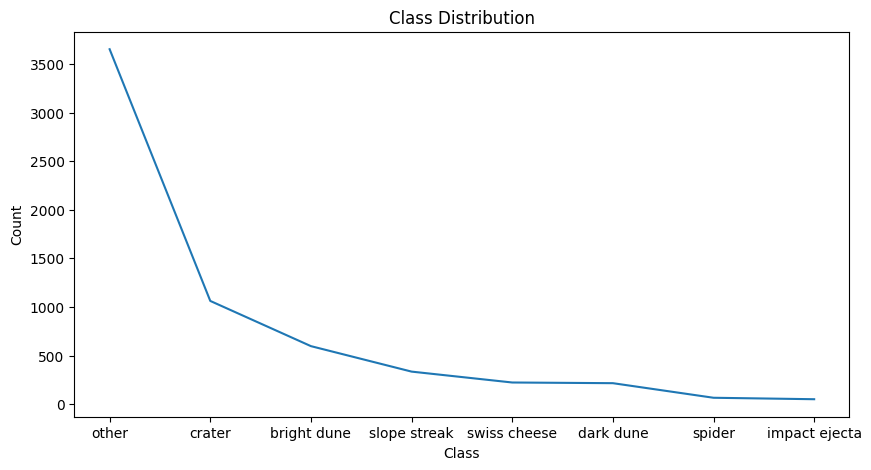

In [10]:
plt.figure(figsize=(10,5))
plt.plot(train_df['Class'].value_counts())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [11]:
# Very High Variance
train_var = np.var(train_df['Class'].value_counts())
train_std = np.std(train_df['Class'].value_counts())
print(f'Variance of training set : {train_var:.2f}')
print(f'Standard Deviation of training set : {train_std:.2f}')

Variance of training set : 1277883.86
Standard Deviation of training set : 1130.44


## Becoming one with the Image Data

### Walk through Directory

In [12]:
def walk_through_dir(image_path):
  for dirpath, dirnames, filenames in os.walk(image_path):
    if len(filenames) == 0:
      print(f'{dirpath} have directories {dirnames}')
    elif len(dirnames) == 0:
      print(f'{dirpath} having {len(filenames)} files')
    else :
      print(f'{dirpath} have directories {dirnames} having {len(filenames)} files')

In [13]:
walk_through_dir(folder_path)

/content/drive/MyDrive/SOI Space Data Science/ have directories ['train_dataset', 'test_dataset'] having 1 files
/content/drive/MyDrive/SOI Space Data Science/train_dataset having 6208 files
/content/drive/MyDrive/SOI Space Data Science/test_dataset having 2000 files


### Visualizing Images : Using PIL

Image Path : /content/drive/MyDrive/SOI Space Data Science/train_dataset/5500.jpg
Image Name : 5500.jpg
Image Size : (227, 227)
Image Mode : L
Image Format : JPEG


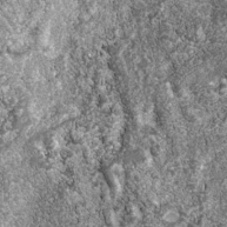

In [14]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

pattern = "*/*.jpg"
image_path_list = list(Path(folder_path).glob(pattern))

random_image = random.choice(image_path_list)

img = Image.open(random_image)

print(f'Image Path : {random_image}')
print(f'Image Name : {random_image.stem}.jpg')
print(f'Image Size : {img.size}')
print(f'Image Mode : {img.mode}')
print(f'Image Format : {img.format}')

img

### Using Matplot

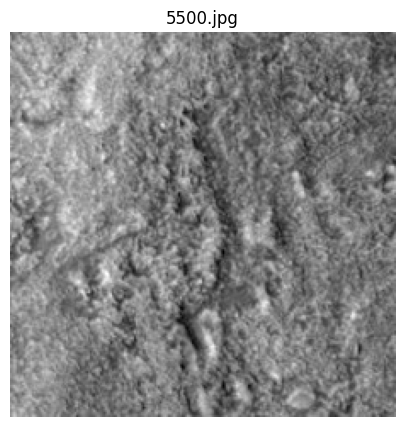

In [15]:
plt.figure(figsize=(7,5))
plt.imshow(img, cmap='gray')
plt.title(f'{random_image.stem}.jpg')
plt.axis(False)
plt.show()

## Building Custom Dataset

### Helper Function

In [16]:
label_df = sorted(train_df['Class'].unique())
label_df

class_with_idx = {label: idx for idx, label in enumerate(label_df)}
class_with_idx

{'bright dune': 0,
 'crater': 1,
 'dark dune': 2,
 'impact ejecta': 3,
 'other': 4,
 'slope streak': 5,
 'spider': 6,
 'swiss cheese': 7}

In [17]:
def get_class_idx(class_name):
  label_df = sorted(train_df['Class'].unique())
  label_df

  class_with_idx = {label: idx for idx, label in enumerate(label_df)}
  return class_with_idx[class_name]

def get_class_name(idx):
  label_df = sorted(train_df['Class'].unique())
  label_df

  return label_df[idx]

In [18]:
get_class_idx('other')

4

### Custom Dataset

In [19]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
      self.data_frame = pd.read_csv(csv_file)
      self.img_dir = img_dir
      self.transform = transform

    def __len__(self):
      return len(self.data_frame)

    def __getitem__(self, idx):
      image_path = os.path.join(self.img_dir, str(self.data_frame.iloc[idx, 0]))
      image = Image.open(image_path)
      label_name = self.data_frame.iloc[idx, 1]
      label_idx = get_class_idx(label_name)

      if self.transform:
          image = self.transform(image)

      return image, label_idx, label_name, image_path



In [20]:
transform = transforms.Compose([
  transforms.Resize((224, 224)),
  transforms.ToTensor()
])


train_data = CustomDataset(csv_file=train_csv, img_dir=train_path, transform=transform)
batch_size = 1
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=False)

train_data, train_dataloader

(<__main__.CustomDataset at 0x796f2c97d1b0>,
 <torch.utils.data.dataloader.DataLoader at 0x796f2c907670>)

In [21]:
image, label_idx, label_name, image_path = next(iter(train_dataloader))
image.shape, label_idx, label_name, image_path

(torch.Size([1, 1, 224, 224]),
 tensor([4]),
 ('other',),
 ('/content/drive/MyDrive/SOI Space Data Science/train_dataset/1.jpg',))

In [22]:
image

tensor([[[[0.3686, 0.3765, 0.3725,  ..., 0.3294, 0.4235, 0.4667],
          [0.3608, 0.3686, 0.3686,  ..., 0.3176, 0.4157, 0.4549],
          [0.3490, 0.3569, 0.3569,  ..., 0.2824, 0.3725, 0.4157],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]]])

Image Name: ('/content/drive/MyDrive/SOI Space Data Science/train_dataset/1.jpg',)


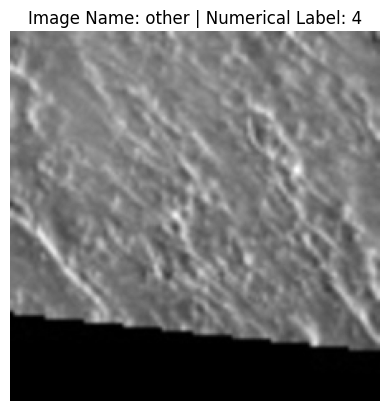

In [23]:
print(f'Image Name: {image_path}')
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f'Image Name: {label_name[0]} | Numerical Label: {label_idx.item()}')
plt.axis('off')
plt.show()

### Visualizing some of the Random Images
- Checking either they are labelled correctly or not

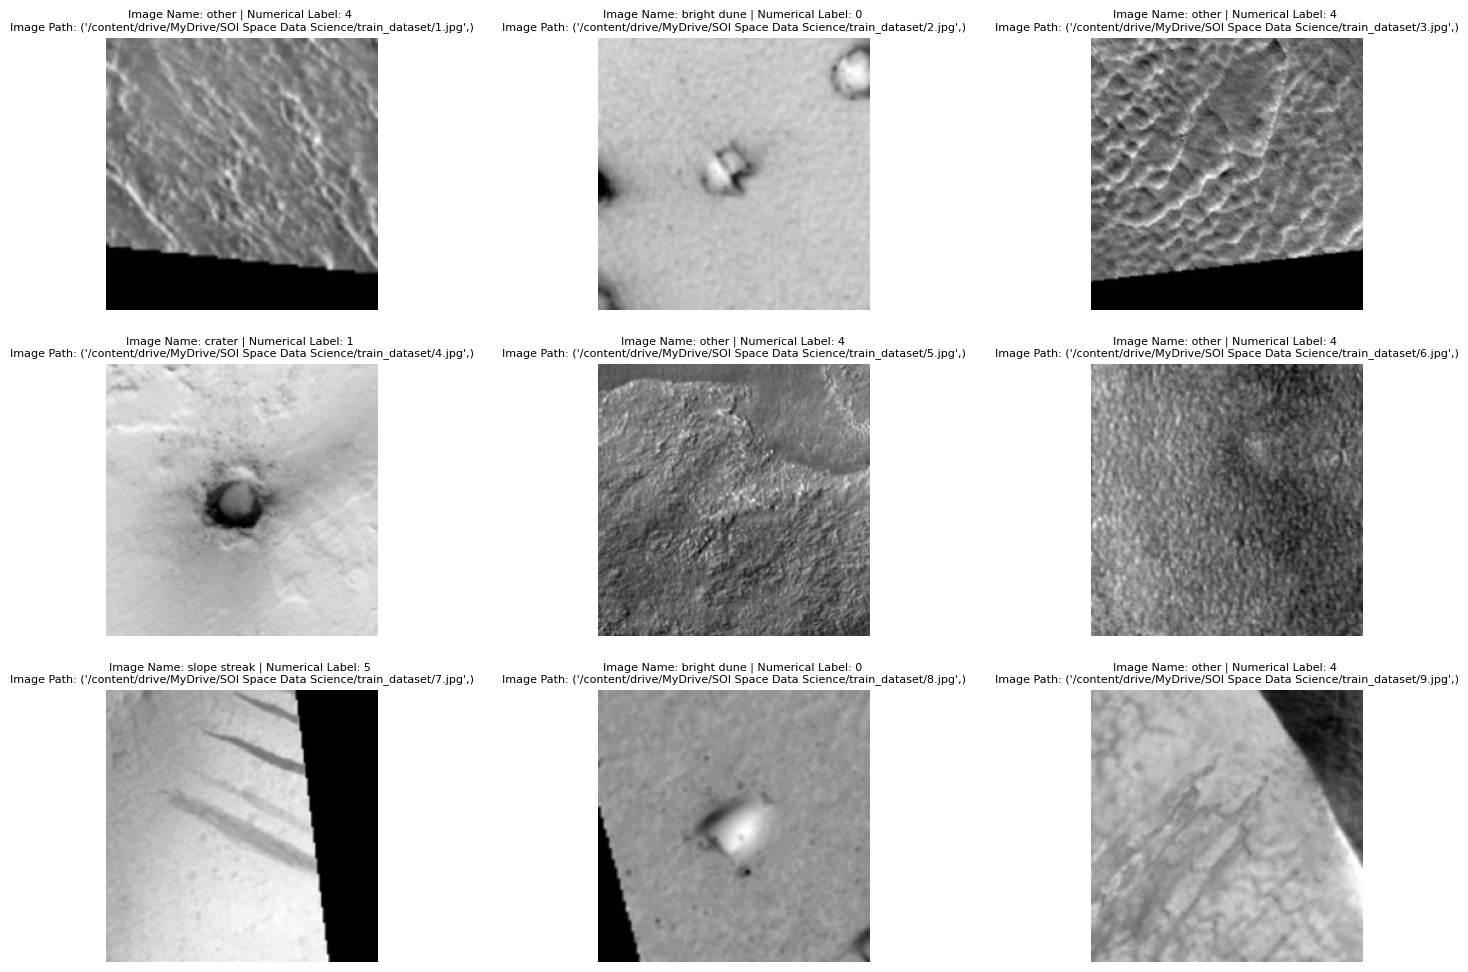

In [24]:
fig = plt.figure(figsize=(18,12))
for i, (image, label_idx, label_name, image_path) in enumerate(train_dataloader):
  if i >= 9:
    break
  fig.add_subplot(3, 3, i+1)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(f'Image Name: {label_name[0]} | Numerical Label: {label_idx.item()} \nImage Path: {image_path}', fontsize=8)
  plt.axis('off')
plt.show()

## Final Dataloader with Image and Label

In [25]:
class CustomDatasetFinal(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
      self.data_frame = pd.read_csv(csv_file)
      self.img_dir = img_dir
      self.transform = transform

    def __len__(self):
      return len(self.data_frame)

    def __getitem__(self, idx):
      image_path = os.path.join(self.img_dir, str(self.data_frame.iloc[idx, 0]))
      image = Image.open(image_path)
      label_name = self.data_frame.iloc[idx, 1]
      label_idx = get_class_idx(label_name)

      if self.transform:
          image = self.transform(image)

      return image, label_idx



In [135]:
transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor(),
  transforms.Normalize((0.5,), (0.5,))
])

BATCH_SIZE = 32

final_dataset = CustomDatasetFinal(csv_file=train_csv, img_dir=train_path, transform=transform)
final_dataset

### Preparing `train_dataloader` and `val_dataloader`

In [136]:
def train_val_dataset_split(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets['train'], datasets['val']


In [137]:
train_dataset, val_dataset = train_val_dataset_split(final_dataset)
print(len(train_dataset))
print(len(val_dataset))
print(train_dataset.dataset)


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(len(train_dataloader))
print(len(val_dataloader))

# x,y = next(iter(train_dataloader))
# print(x.shape, y.shape)

# x,y = next(iter(val_dataloader))
# print(x.shape, y.shape)

4960
1241
155
39


## Making Model : Subclassing nn.Module

### Base Model : Linear

#### Defining Model Class

In [120]:
class ModelV0(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_shape)
    )

  def forward(self, x):
    return self.layers(x)


#### Device Agnostic Code

In [121]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Initializing Model

In [122]:
model_0 = ModelV0(
    input_shape=128*128,
    hidden_units=64,
    output_shape=8
).to(device)

model_0

ModelV0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=16384, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=8, bias=True)
  )
)

#### Defining Loss Function, Optimizer and Accuracy metric

In [123]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(params=model_0.parameters(), lr=0.001)
accuracy_fn = Accuracy(task='multiclass', num_classes=8).to(device)

#### Training and Testing Loop

In [124]:
EPOCHS = 5

start_time = timer()
for epoch in tqdm(range(EPOCHS)):
  print(f'\nEPOCH : {epoch+1} \n----------')
  train_loss = 0
  train_acc = 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    model_0.train()

    y_logits = model_0(X)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y)
    acc = accuracy_fn(y_pred, y)
    train_loss += loss
    train_acc += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 50 == 0:
      print(f'Looked at {batch * len(X)/len(train_dataloader.dataset):.2f} samples')

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f'Train Loss : {train_loss:.5f} | Train Accuracy : {train_acc:.3f}')

  val_loss = 0
  val_acc = 0
  model_0.eval()
  with torch.inference_mode():
    for X, y in val_dataloader:
      X, y = X.to(device), y.to(device)

      val_logits = model_0(X)
      val_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)
      val_loss += loss_fn(val_logits, y)
      val_acc += accuracy_fn(val_pred, y)

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    print(f'Val Loss : {val_loss:.5f} | Val Accuracy : {val_acc:.3f}')

end_time = timer()
total_time = end_time - start_time
print(f'Total Time : {total_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]


EPOCH : 1 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 2.51536 | Train Accuracy : 0.329
Val Loss : 2.00742 | Val Accuracy : 0.389

EPOCH : 2 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 1.67069 | Train Accuracy : 0.487
Val Loss : 2.03272 | Val Accuracy : 0.475

EPOCH : 3 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 1.48054 | Train Accuracy : 0.560
Val Loss : 1.50974 | Val Accuracy : 0.535

EPOCH : 4 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 1.39356 | Train Accuracy : 0.584
Val Loss : 1.42313 | Val Accuracy : 0.550

EPOCH : 5 
----------
Looked at 0.00 samples
Looked at 0.32 samples
Looked at 0.65 samples
Looked at 0.97 samples
Train Loss : 1.23488 | Train Accuracy : 0.617
Val Loss : 1.53049 | Val Ac

#### Evaluation Function
- Returns a dictionary related to Evaluation of Model

In [34]:
def eval_model(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    accuracy_fn
):
  start_time = timer()

  loss, acc = 0, 0

  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)
      y_logits = model(X)

      loss += loss_fn(y_logits, y)
      acc += accuracy_fn(y_logits.argmax(dim=1), y)

    loss /= len(data_loader)
    acc /= len(data_loader)

  end_time = timer()

  return {
      'model_name': model.__class__.__name__,
      'model_acc': acc.item(),
      'model_loss': loss.item(),
      'model_eval_time': end_time-start_time
  }

#### Evaluating Model 0

In [35]:
model_0_dict = eval_model(
    model=model_0,
    data_loader=val_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

In [36]:
model_0_dict

{'model_name': 'ModelV0',
 'model_acc': 0.5959615707397461,
 'model_loss': 1.2972378730773926,
 'model_eval_time': 4.946153312999968}

### Model with Non-Linearity

#### Defining Model Class

In [ ]:
class ModelV1(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=input_shape, out_features=hidden_units),
      nn.ReLU(),
      nn.Linear(in_features=hidden_units, out_features=output_shape),
      nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

#### Initializing Model

In [ ]:
model_1 = ModelV1(input_shape=28*28,
    hidden_units=10,
    output_shape=8
).to(device)

model_1

ModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=8, bias=True)
    (4): ReLU()
  )
)

#### Defining Loss function, Optimizer and Accuracy metric

In [ ]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.001)
accuracy_fn = Accuracy(task='multiclass', num_classes=8).to(device)

loss_fn, optimizer, accuracy_fn

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 MulticlassAccuracy())

#### Training and Testing Loop

In [ ]:
EPOCHS = 5

start_time = timer()
for epoch in tqdm(range(EPOCHS)):
  print(f'\nEPOCH : {epoch+1} \n----------')
  train_loss = 0
  train_acc = 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    model_1.train()

    y_logits = model_1(X)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y)
    acc = accuracy_fn(y_pred, y)
    train_loss += loss
    train_acc += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 100 == 0:
      print(f'Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples')

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  print(f'Train Loss : {train_loss:.5f} | Train Accuracy : {train_acc:.3f}')

  val_loss = 0
  val_acc = 0
  model_1.eval()
  with torch.inference_mode():
    for X, y in val_dataloader:
      X, y = X.to(device), y.to(device)

      val_logits = model_1(X)
      val_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)
      val_loss += loss_fn(val_logits, y)
      val_acc += accuracy_fn(val_pred, y)

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    print(f'Val Loss : {val_loss:.5f} | Val Accuracy : {val_acc:.3f}')

end_time = timer()
total_time = end_time - start_time
print(f'Total Time : {total_time:.3f} seconds')

  0%|          | 0/5 [00:00<?, ?it/s]


EPOCH : 1 
----------
Looked at 0/4960 samples
Looked at 3200/4960 samples
Train Loss : 1.60419 | Train Accuracy : 0.584
Val Loss : 1.56969 | Val Accuracy : 0.582

EPOCH : 2 
----------
Looked at 0/4960 samples
Looked at 3200/4960 samples
Train Loss : 1.55244 | Train Accuracy : 0.590
Val Loss : 1.56083 | Val Accuracy : 0.582

EPOCH : 3 
----------
Looked at 0/4960 samples
Looked at 3200/4960 samples
Train Loss : 1.54431 | Train Accuracy : 0.590
Val Loss : 1.55426 | Val Accuracy : 0.582

EPOCH : 4 
----------
Looked at 0/4960 samples
Looked at 3200/4960 samples
Train Loss : 1.53785 | Train Accuracy : 0.590
Val Loss : 1.54950 | Val Accuracy : 0.582

EPOCH : 5 
----------
Looked at 0/4960 samples
Looked at 3200/4960 samples
Train Loss : 1.53269 | Train Accuracy : 0.590
Val Loss : 1.54144 | Val Accuracy : 0.582
Total Time : 124.163 seconds


#### Evaluating Model 1

In [ ]:
model_1_dict = eval_model(
    model=model_1,
    data_loader=val_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_1_dict

{'model_name': 'ModelV1',
 'model_acc': 0.5822436213493347,
 'model_loss': 1.541437029838562,
 'model_eval_time': 4.7553368540000065}

### CNN Model

#### Defining Model Class

In [154]:
class ModelV2(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(hidden_units),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                  stride=1,
                   padding=1),
      nn.BatchNorm2d(hidden_units),
      nn.Dropout(0.4)
    )
    self.block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=2*hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(2*hidden_units),
      nn.Conv2d(in_channels=2*hidden_units,
                out_channels=2*hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                    stride=1,
                   padding=1),
      nn.BatchNorm2d(2*hidden_units),
      nn.Dropout(0.4)
    )
    self.block_3 = nn.Sequential(
      nn.Conv2d(in_channels=2*hidden_units,
                out_channels=3*hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(3*hidden_units),
      nn.Conv2d(in_channels=3*hidden_units,
                out_channels=3*hidden_units,
                kernel_size=3,
                stride=2,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2,
                  stride=2,
                   padding=1),
      nn.BatchNorm2d(3*hidden_units),
      nn.Dropout(0.4)
    )
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=3*hidden_units*17*17,
                out_features=output_shape),
      nn.Dropout(0.4),
      nn.Linear(in_features=output_shape,
                out_features=output_shape)
    )

  def forward(self, x: torch.Tensor):
    # print(x.shape)
    x = self.block_1(x)
    # print(x.shape)
    x = self.block_2(x)
    # print(x.shape)
    x = self.block_3(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x


#### Device agnostic code

In [155]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Intializing Model

In [156]:
model_2 = ModelV2(
    input_shape=1,
    hidden_units=64,
    output_shape=8
).to(device)

model_2

ModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
  )
  (block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dr

#### Defining Loss function, Optimizer and Accuracy metric

In [157]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(
    params=model_2.parameters(),
    lr=0.001
)
accuracy_fn = Accuracy(task='multiclass', num_classes=8).to(device)

loss_fn, optimizer, accuracy_fn

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ),
 MulticlassAccuracy())

#### Training and Testing Loop

In [158]:
EPOCHS = 40

start_time = timer()
train_loss_hist = []
train_acc_hist = []
val_loss_hist = []
val_acc_hist = []

for epoch in tqdm(range(EPOCHS)):
  print(f'\nEPOCH : {epoch+1} \n----------')
  train_loss = 0
  train_acc = 0
  for batch, (X, y) in enumerate(train_dataloader):
    X, y = X.to(device), y.to(device)

    model_2.train()

    y_logits = model_2(X)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y)
    acc = accuracy_fn(y_pred, y)
    train_loss += loss
    train_acc += acc

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch % 50 == 0:
      print(f'Looked at {(batch * len(X))/len(train_dataloader.dataset):.2f} samples')

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  train_loss_hist.append(train_loss.item())
  train_acc_hist.append(train_acc.item())

  print(f'Train Loss : {train_loss:.5f} | Train Accuracy : {train_acc:.3f}')

  val_loss = 0
  val_acc = 0
  model_2.eval()
  with torch.inference_mode():
    for X, y in val_dataloader:
      X, y = X.to(device), y.to(device)

      val_logits = model_2(X)
      val_pred = torch.softmax(val_logits, dim=1).argmax(dim=1)
      val_loss += loss_fn(val_logits, y)
      val_acc += accuracy_fn(val_pred, y)

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)
    val_loss_hist.append(val_loss.item())
    val_acc_hist.append(val_acc.item())

    print(f'Val Loss : {val_loss:.5f} | Val Accuracy : {val_acc:.3f}')

end_time = timer()
total_time = end_time - start_time
print(f'Total Time : {total_time:.3f} seconds\n')

print(f"Training Losses : {train_loss_hist}\n")
print(f"Training Accuracies : {train_acc_hist}\n")
print(f"Validation Losses : {val_loss_hist}\n")
print(f"Validation Accuracies : {val_acc_hist}")

  0%|          | 0/40 [00:00<?, ?it/s]


EPOCH : 1 
----------
Looked at 0.00 samples
Looked at 0.65 samples
Train Loss : 4.68700 | Train Accuracy : 0.447
Val Loss : 2.35486 | Val Accuracy : 0.600

EPOCH : 2 
----------
Looked at 0.00 samples
Looked at 0.65 samples
Train Loss : 2.51459 | Train Accuracy : 0.562
Val Loss : 2.08940 | Val Accuracy : 0.685

EPOCH : 3 
----------
Looked at 0.00 samples
Looked at 0.65 samples
Train Loss : 1.77998 | Train Accuracy : 0.614
Val Loss : 1.13990 | Val Accuracy : 0.728

EPOCH : 4 
----------
Looked at 0.00 samples
Looked at 0.65 samples
Train Loss : 1.27275 | Train Accuracy : 0.669
Val Loss : 1.01082 | Val Accuracy : 0.722

EPOCH : 5 
----------
Looked at 0.00 samples
Looked at 0.65 samples
Train Loss : 1.04680 | Train Accuracy : 0.693
Val Loss : 0.78738 | Val Accuracy : 0.738

EPOCH : 6 
----------
Looked at 0.00 samples
Looked at 0.65 samples
Train Loss : 0.92740 | Train Accuracy : 0.712
Val Loss : 0.79078 | Val Accuracy : 0.750

EPOCH : 7 
----------
Looked at 0.00 samples
Looked at 0.

#### Evaluating Model 2

In [ ]:
model_2_dict = eval_model(
    model=model_2,
    data_loader=val_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_2_dict


### All Model Performance measure

In [ ]:
performance_df = {
    'model_name': [model_0_dict['model_name'], model_1_dict['model_name'], model_2_dict['model_name']],
    'model_acc': [model_0_dict['model_acc'], model_1_dict['model_acc'], model_2_dict['model_acc']],
    'model_loss': [model_0_dict['model_loss'], model_1_dict['model_loss'], model_2_dict['model_loss']],
    'model_time': [model_0_dict['model_eval_time'], model_1_dict['model_eval_time'], model_2_dict['model_eval_time']]
}

performance_df = pd.DataFrame(performance_df)
performance_df


In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Accuracy')
plt.plot(performance_df['model_name'], performance_df['model_acc'], label='Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(performance_df['model_name'], performance_df['model_loss'], label='Loss')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.legend()

plt.show()